In [8]:
import pybinding as pb
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

In [2]:
from pybinding.constants import phi0


def constant_magnetic_field(B):
    @pb.hopping_energy_modifier
    def function(energy, x1, y1, x2, y2):
        # the midpoint between two sites
        y = 0.5 * (y1 + y2)
        # scale from nanometers to meters
        y *= 1e-9

        # vector potential along the x-axis
        A_x = B * y

        # integral of (A * dl) from position 1 to position 2
        peierls = A_x * (x1 - x2)
        # scale from nanometers to meters (because of x1 and x2)
        peierls *= 1e-9

        # the Peierls substitution
        return energy * np.exp(1j * 2*pi/phi0 * peierls)
    return function


def triaxial_strain(c, beta=3.37):
    """Produce both the displacement and hopping energy modifier"""
    @pb.site_position_modifier
    def displacement(x, y, z):
        ux = 2*c * x*y
        uy = c * (x**2 - y**2)
        return x + ux, y + uy, z

    @pb.hopping_energy_modifier
    def strained_hopping(energy, x1, y1, z1, x2, y2, z2):
        l = np.sqrt((x1-x2)**2 + (y1-y2)**2 + (z1-z2)**2)
        w = l / graphene.a_cc - 1
        return energy * np.exp(-beta*w)

    return displacement, strained_hopping


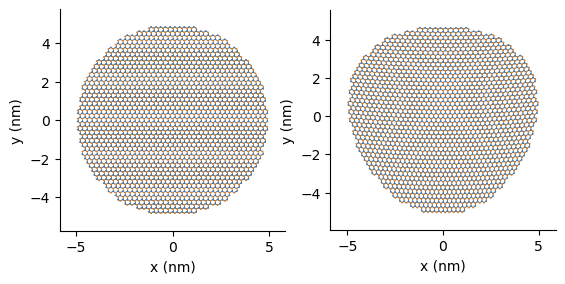

In [133]:
from pybinding.repository import graphene

from math import pi

model_mag = pb.Model(
    graphene.monolayer(),
    pb.circle(radius=5),
    constant_magnetic_field(B=600)  # Tesla
)
kpm_mag = pb.kpm(model_mag)

model_strain = pb.Model(
    graphene.monolayer(),
    pb.circle(radius=5),
    triaxial_strain(c=.0093)
)

kpm_strain = pb.kpm(model_strain)

plt.subplot(1,2,1)
model_mag.plot()
plt.subplot(1, 2, 2)
model_strain.plot()


In [77]:
def ldos_diff(p):

    B,c = p
    model_mag = pb.Model(
        graphene.monolayer(),
        pb.circle(radius=5),
        constant_magnetic_field(B=B)  # Tesla
    )


    kpm_mag = pb.kpm(model_mag)

    model_strain = pb.Model(
        graphene.monolayer(),
        pb.circle(radius=5),
        triaxial_strain(c=c)
    )

    kpm_strain = pb.kpm(model_strain)

    ldos_mag = kpm_mag.calc_ldos(energy=np.linspace(-2, 2, 500),
                                 broadening=0.03, position=[0, 0])

    ldos_strain = kpm_strain.calc_ldos(energy=np.linspace(-2, 2, 500),
                                       broadening=0.03, position=[0, 0])

    return np.sqrt(np.mean((ldos_mag.data - ldos_strain.data)**2))



In [102]:
ldos_diff([580,.01])

0.038930441954408465

In [79]:
minimize(ldos_diff,x0=[300,.1], method = 'Nelder-Mead')

 final_simplex: (array([[ 5.73724243e+02, -2.32137377e-03],
       [ 5.73724244e+02, -2.32137350e-03],
       [ 5.73724303e+02, -2.32137454e-03]]), array([0.02089366, 0.02089368, 0.02089382]))
           fun: 0.020893658004421587
       message: 'Optimization terminated successfully.'
          nfev: 120
           nit: 50
        status: 0
       success: True
             x: array([ 5.73724243e+02, -2.32137377e-03])

In [151]:
energy_range = np.linspace(-1,1, 1000)
np.diff(energy_range)[0]

0.002002002002001957

(0.0, 50.0)

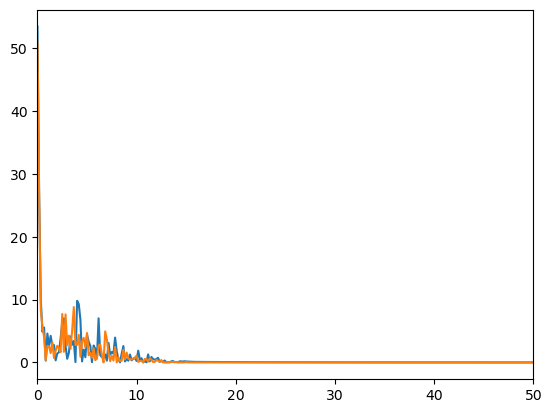

In [156]:
from scipy.fft import rfft
from scipy.fft import rfftfreq

freqs=rfftfreq(len(ldos1.data), np.diff(energy_range)[0])


plt.plot(freqs,np.abs(rfft(ldos1.data)))
plt.plot(freqs,np.abs(rfft(ldos2.data)))
plt.xlim(0,50)

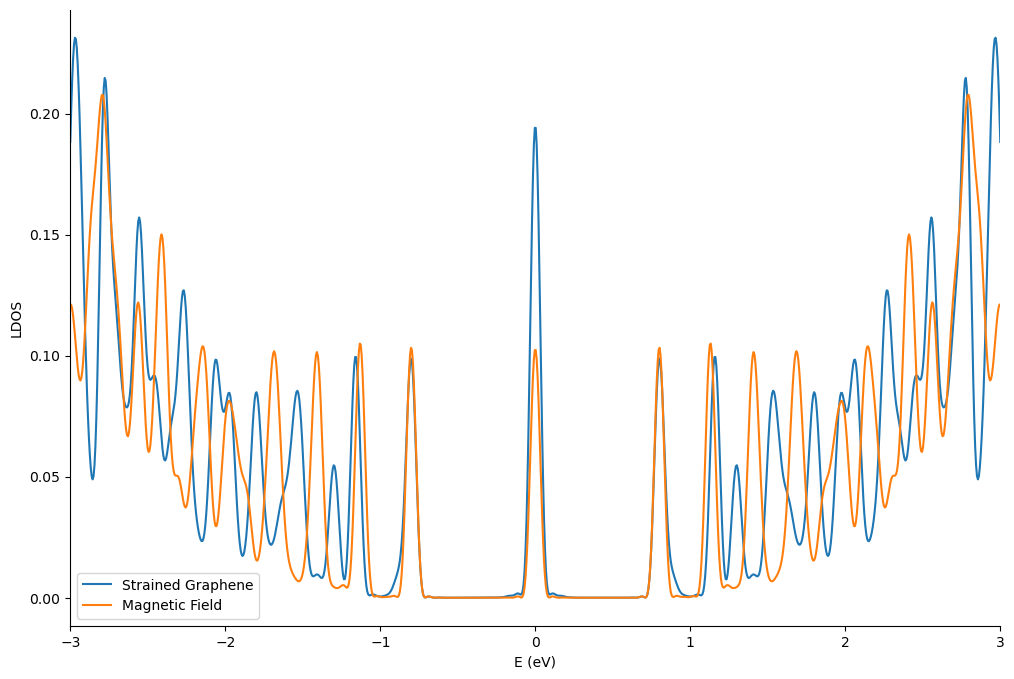

In [155]:
energy_range = np.linspace(-3,3, 1000)

ldos1 = kpm_strain.calc_ldos(energy=energy_range,
                     broadening=0.03, position=[0, 0])

ldos2 = kpm_mag.calc_ldos(energy=energy_range,
                             broadening=0.03, position=[0, 0])

plt.figure(figsize=(12,8))
ldos1.plot(label="Strained Graphene")
ldos2.plot(label="Magnetic Field")
plt.legend()
plt.show()
